Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**


In [472]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
import wandb
%matplotlib inline

In [473]:
np.random.seed(42)
torch.cuda.manual_seed(42)


# TP3: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




In [474]:
project_name='Music_genre_classification'
wandb.login(key = "451637d95c22df4568c6f5a268e37071bc14547b")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/msinnona/.netrc


True

### 2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





In [475]:
#from google.colab import drive
#drive.mount('/content/drive')

data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [476]:
import os
data_dir='./genres_5sec'
list_files=os.listdir(data_dir)
classes=[]

for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

['rock',
 'disco',
 'blues',
 'hiphop',
 'reggae',
 'jazz',
 'classical',
 'country',
 'metal',
 'pop']

In [477]:
samplerate=22050

def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    
    def __init__(self, root):
        
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):

        fname = self.files[i]

        #img = self.transform(open_image(fpath))
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        
        audio = torchaudio.load(fpath)[0].squeeze()

        return audio, class_idx
    
dataset = MusicDataset(data_dir)

### 3. Visualización de los archivos

In [478]:
waveform,label = dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([110250]), sample rate with 22050, label is 1 


shape of spectogram torch.Size([201, 552])


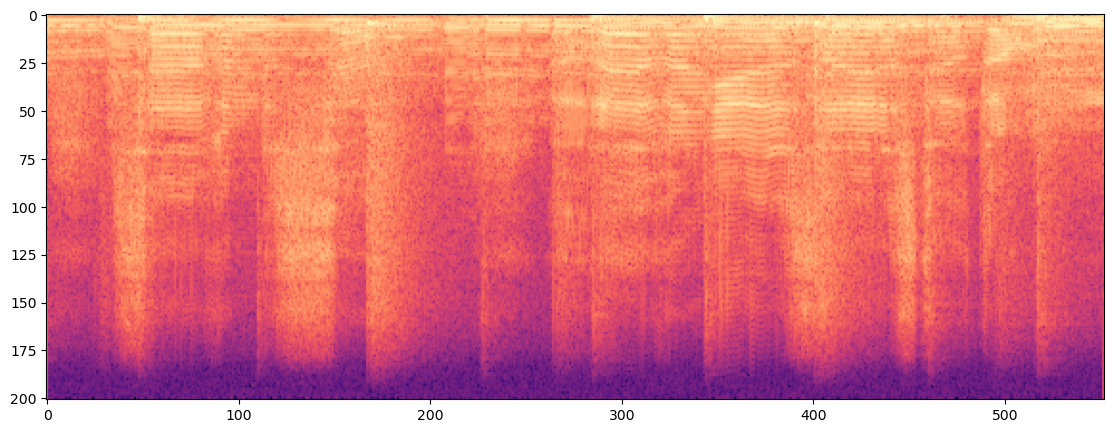

In [479]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[:,:].numpy(),cmap='magma')


Waveform: tensor([ 0.1121,  0.1816,  0.1665,  ..., -0.0149, -0.0296, -0.0053])



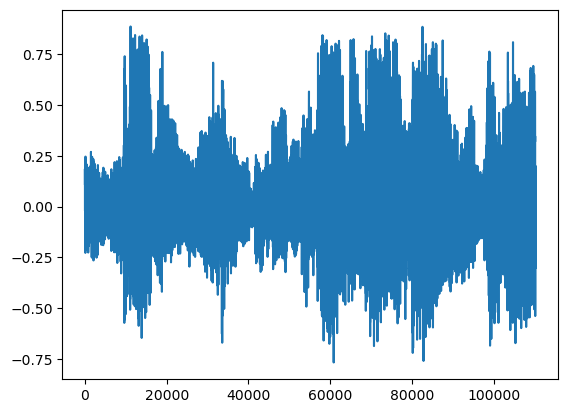

In [480]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [481]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [482]:
specgram.size()

torch.Size([201, 552])

In [483]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [484]:
from torch.utils.data import DataLoader
batch_size = 400

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=0, pin_memory=True)

### 4. Clasificación

In [485]:
class MLP(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output=10):
        
        super(MLP, self).__init__()

        self.pool = nn.MaxPool1d(kernel_size = 10)
        self.fc1 = nn.Linear(n_input // 10, n_hidden, bias = True)  
        self.fc2 = nn.Linear(n_hidden, n_output, bias = True)  

    def forward(self, x):
        
        x = self.pool(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
    
        return F.log_softmax(x, dim=1)

In [486]:
audio, _ = dataset[0]
len(audio)

110250

In [487]:

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = MLP(n_input=len(audio), n_hidden=256, n_output=len(classes))
model.to(device)

print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

MLP(
  (pool): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11025, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Number of parameters: 2825226


In [488]:
len(classes)

10

In [489]:
import gc
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn.functional as F

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
valid_losses = []
num_epochs = 20

wandb.init(
        project = "td6-tp3",
        name = "a", 
        entity = "martinsinnona", 
        config = {"model": model}
    )

torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram

train_losses = []
val_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    losses = []

    # Train
    model.train()

    for wav, genre_index in train_dl:
        
        optimizer.zero_grad()  # Clear gradients
        
        wav = wav.to(device)
        genre_index = torch.as_tensor(genre_index).to(device)

        # Forward
        out = model(wav)
        loss = loss_function(out.squeeze(), genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram

        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    train_losses.append(np.mean(losses))
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    model.eval()

    y_true = []
    y_pred = []
    losses = []
    correct =0

    for wav, genre_index in valid_dl:
        
        #print(wav, genre, index)
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        loss = loss_function(out.squeeze() , genre_index)

        losses.append(loss.item())
        pred = out.argmax(dim=-1).flatten()

        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

        del wav #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram

        torch.cuda.empty_cache()  #importante para ir liberando memoria ram
        gc.collect() #importante para ir liberando memoria ram

    accuracy =correct/ len(valid_dl.dataset)
    valid_loss = np.mean(losses)

    val_losses.append(valid_loss)
    accuracies.append(accuracy)

    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    
    wandb.log({"epoch": epoch, "train_loss": train_losses[-1], "val_loss": valid_losses[-1], "val_accuracy": accuracy})

    if np.argmin(valid_losses) == epoch:
        
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(model.state_dict(), 'best_model.ckpt')

wandb.finish()

Epoch: [1/20], Train loss: 2.2991
Epoch: [1/20], Valid loss: 2.2289, Valid accuracy: 0.1200
Saving the best model at 0 epochs!
Epoch: [2/20], Train loss: 2.1669
Epoch: [2/20], Valid loss: 2.2281, Valid accuracy: 0.1100
Saving the best model at 1 epochs!
Epoch: [3/20], Train loss: 2.0514
Epoch: [3/20], Valid loss: 2.1970, Valid accuracy: 0.1700
Saving the best model at 2 epochs!
Epoch: [4/20], Train loss: 1.9226
Epoch: [4/20], Valid loss: 2.2191, Valid accuracy: 0.2100
Epoch: [5/20], Train loss: 1.7949
Epoch: [5/20], Valid loss: 2.2292, Valid accuracy: 0.2200
Epoch: [6/20], Train loss: 1.6709
Epoch: [6/20], Valid loss: 2.2271, Valid accuracy: 0.1700
Epoch: [7/20], Train loss: 1.5498
Epoch: [7/20], Valid loss: 2.2391, Valid accuracy: 0.2100
Epoch: [8/20], Train loss: 1.4347
Epoch: [8/20], Valid loss: 2.2537, Valid accuracy: 0.2200
Epoch: [9/20], Train loss: 1.3253
Epoch: [9/20], Valid loss: 2.2801, Valid accuracy: 0.2300
Epoch: [10/20], Train loss: 1.2238
Epoch: [10/20], Valid loss: 2.29

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▂▁▅▇▇▅▇▇█▇▇▇▆▅▄▇▆▅▄▅
val_loss,▂▂▁▁▂▂▂▂▂▃▃▄▄▄▅▆▆▇▇█
epoch,19
train_loss,0.53949
val_accuracy,0.17
val_loss,2.58572


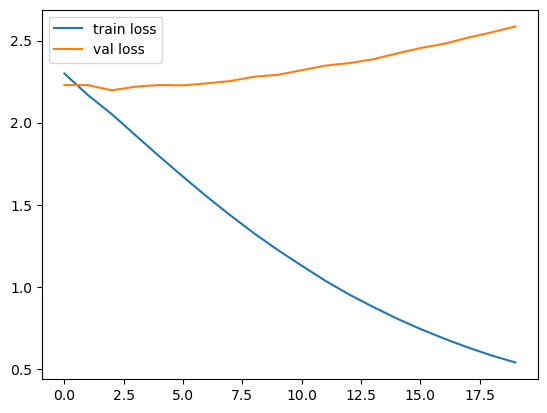

In [490]:
plt.plot(train_losses, label = "train loss")
plt.plot(val_losses, label = "val loss")

plt.legend()

(0.0, 1.0)

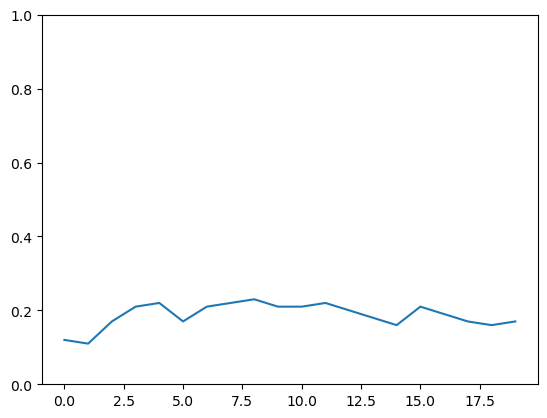

In [491]:
plt.plot(accuracies, label = "accuracy")
plt.ylim(0,1)



### 5. Evaluación



In [492]:
test_dl = DataLoader(test_ds,1,shuffle=True, num_workers=0, pin_memory=True)

In [493]:
# Load the best model
S = torch.load('best_model.ckpt')
model.load_state_dict(S)
print('loaded!')

# Run evaluation
model.eval()
y_true = []
y_pred = []
correct = 0

with torch.no_grad():
    for wav, genre_index in test_dl:
        
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy =correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

loaded!
Epoch: [20/20], Valid loss: 2.5857, Valid accuracy: 0.1000


In [494]:
waveform,label= test_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([110250]), sample rate with 22050, label is 9 


In [495]:
import IPython
IPython.display.Audio(waveform, rate=22050)

In [496]:
wav = torch.unsqueeze(waveform, dim = 0)
model.to(device)
wav = wav.to(device)
out = model(wav)
pred = out.argmax(dim = -1).flatten()
classes[pred], classes[label]

('metal', 'pop')